# Flight Price Prediction #
## Introduction ##
This Notebook tries to find an answer to the question "What is the best time to book a flight?".
The dataset used in this notebook is provided by Prof. Dr. Martin Spott and Manu Mutthatu.
It contains flight data from 2019 for the following routes:
-   London Stansted and Berlin Schönefeld
-   London Stansted and Frankfurt

In [88]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Get the data ##

In [89]:
# read in the data
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')

## Explore the data (Data Exploration) ##

In [90]:
# make a copy of the data
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

# check the data
df_train_copy.head()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1


we can see that the data contains the following columns:
-   index: index of the row
-   request_date: date when the request was made
-   flight_date: date when the flight took place
-   departure_hour: hour when the flight departed
-   flight_unique_id: unique id for each flight
-   route_abb: abbreviation of the route
-   price_in_eur: price of the flight in euro
-   min_future_price_in_euro: minimum price of the flight in euro for all future request dates
-   buy: 1 if the flight should be bought, 0 if not (TODO: check if this is correct)

In [91]:
# check the number of rows and columns
df_train_copy.shape

(83624, 9)

we can see that the data contains 83624 rows and 9 columns.

In [92]:
# check the data types
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83624 entries, 0 to 83623
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    83624 non-null  int64  
 1   Request_Date             83624 non-null  object 
 2   Flight_Date              83624 non-null  object 
 3   Departure_hour           83624 non-null  int64  
 4   flight_unique_id         83624 non-null  object 
 5   route_abb                83624 non-null  object 
 6   Price_In_Eur             83624 non-null  float64
 7   min_future_price_in_Eur  83624 non-null  float64
 8   buy                      83624 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 5.7+ MB


we can see that the data types are correct, except for the date columns. We will deal with that later.

In [93]:
# check if there are any missing values
df_train_copy.isnull().sum()

index                      0
Request_Date               0
Flight_Date                0
Departure_hour             0
flight_unique_id           0
route_abb                  0
Price_In_Eur               0
min_future_price_in_Eur    0
buy                        0
dtype: int64

You can see that there are no missing values in the data.

In [94]:
# check the noise in the data
df_train_copy.describe()

,index,Departure_hour,Price_In_Eur,min_future_price_in_Eur,buy
count,83624.000000,83624.000000,83624.000000,83624.000000,83624.000000
mean,41812.500000,12.969889,71.965080,56.593014,0.223835
std,24140.313792,6.177936,54.788483,46.126909,0.416815
min,1.000000,6.000000,8.990000,8.990000,0.000000
25%,20906.750000,7.000000,32.770000,22.270000,0.000000
50%,41812.500000,10.000000,55.080000,41.890000,0.000000
75%,62718.250000,19.000000,91.790000,73.430000,0.000000
max,83624.000000,22.000000,372.960000,311.090000,1.000000


88.73     2531
73.43     2316
106.07    1840
45.89     1735
19.99     1545
          ... 
62.99        1
123.22       1
173.10       1
205.65       1
59.70        1
Name: Price_In_Eur, Length: 2868, dtype: int64


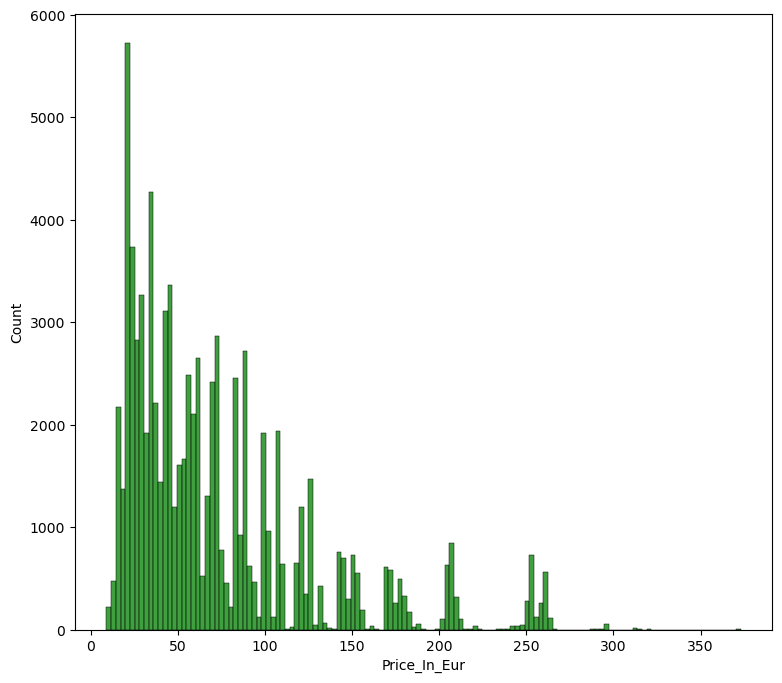

In [95]:
# check the distribution of Price in Euro
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Price_In_Eur'], color='g');

# check the most common price
print(df_train_copy['Price_In_Eur'].value_counts())


The prices seem to be quite evenly distributed. There are fluctuations in the higher prices that seem to be repeated. Also there seems to be some outliers in prices around and above 350€.

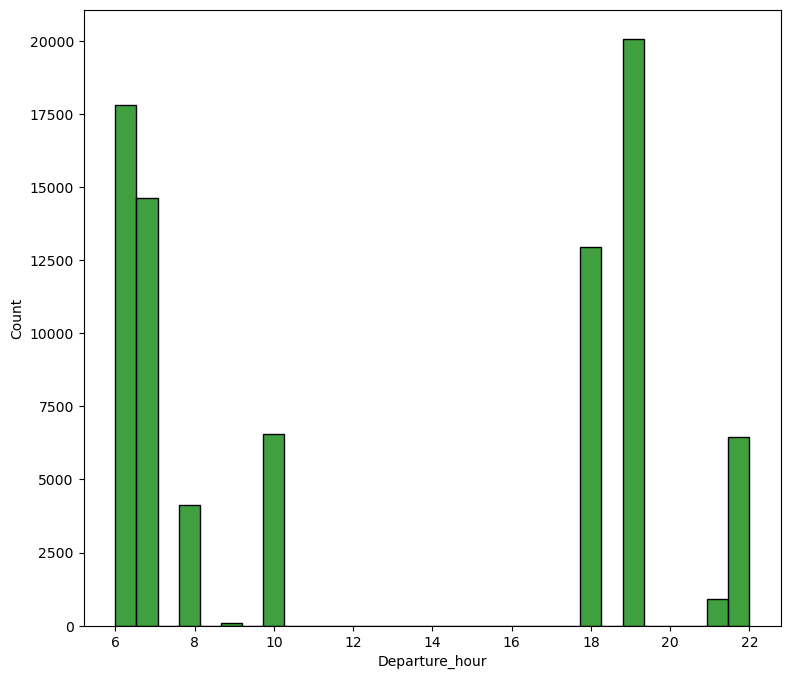

In [96]:
# check the distribution of Departure hour
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Departure_hour'], color='g');

In [97]:
# check the amounts of data with Departure hour between 12 and 16
df_train_copy[(df_train_copy['Departure_hour'] >= 12) & (df_train_copy['Departure_hour'] <= 16)].shape[0]

0

The earliest flights depart at 6, the latest at 22. Most flights seem to depart in the morning or in the evening. There are no flights departing in the afternoon between 12 and 16.

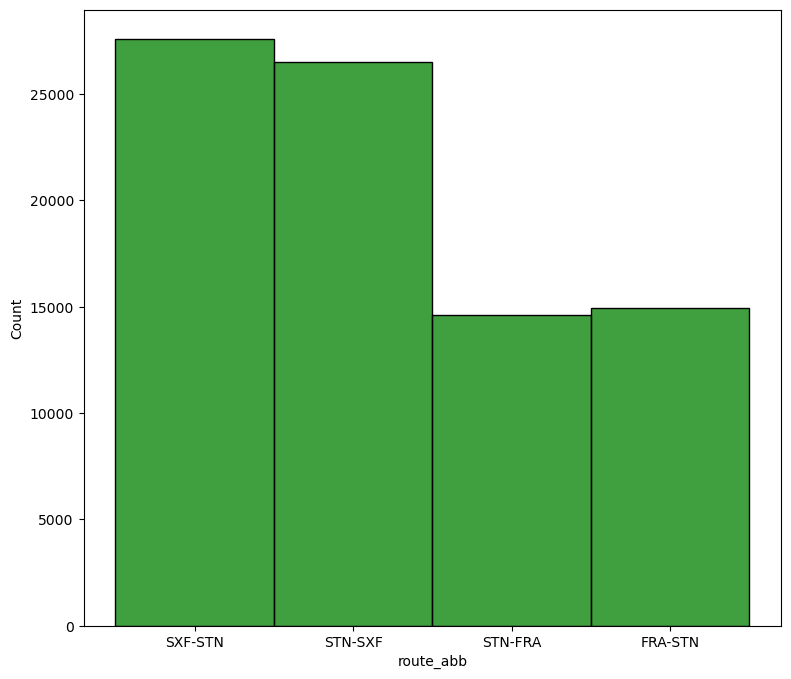

In [98]:
# check the distribution of route abb
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['route_abb'], color='g');

In [99]:
# One hot encoding to convert categorical variables route_abb to numerical
df_train_copy = pd.get_dummies(df_train_copy, columns=['route_abb'], prefix=['route'])

# check the data
df_train_copy.head()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,Price_In_Eur,min_future_price_in_Eur,buy,route_FRA-STN,route_STN-FRA,route_STN-SXF,route_SXF-STN
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,208.07,259.07,1,0,0,0,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,259.07,259.07,1,0,0,0,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,259.07,259.07,1,0,0,0,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,259.07,259.07,1,0,0,0,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,143.86,251.72,1,0,0,1,0


The data contains 2 routes: SXF-STN and STN-FRA additionally for both of those routes there are flights in both directions. There are a little more than 10000 more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA.

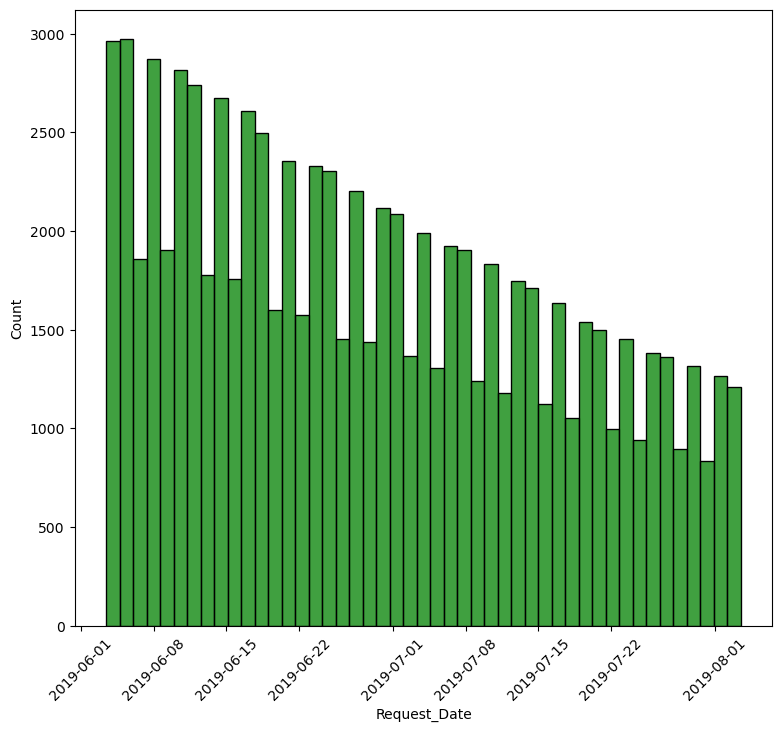

In [100]:
# check the distribution of the request date
# convert the request date to datetime
df_train_copy['Request_Date'] = pd.to_datetime(df_train_copy['Request_Date'])

plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Request_Date'], color='g');

# rotate the x axis value description to make it more readable
plt.xticks(rotation=45);

# make a more useful plot for the request date
# df_train_copy['Request_Date'].value_counts().plot(figsize=(9, 8));

In [101]:
# check for outliers in request date
print(df_train_copy[df_train_copy['Request_Date'] < '2019-01-01'].shape[0])

# check the last date in the data
print(df_train_copy['Request_Date'].min())
print(df_train_copy['Request_Date'].max())

0
2019-06-03 11:00:00+00:00
2019-08-03 11:00:00+00:00


The data contains requests from 2019-06-03 to 2019-08-03. There are no outliers in the request date.

In [102]:
# check the last request date for each flight
df_train_copy.groupby('flight_unique_id')['Request_Date'].max()

flight_unique_id
2019-06-05 FR 146    2019-06-04 23:00:00+00:00
2019-06-05 FR 147    2019-06-04 23:00:00+00:00
2019-06-05 FR 8545   2019-06-04 23:00:00+00:00
2019-06-06 FR 144    2019-06-05 11:00:00+00:00
2019-06-06 FR 146    2019-06-05 23:00:00+00:00
                                ...           
2019-09-09 FR 8545   2019-08-03 11:00:00+00:00
2019-09-10 FR 144    2019-08-03 11:00:00+00:00
2019-09-10 FR 145    2019-08-03 11:00:00+00:00
2019-09-10 FR 8542   2019-08-03 11:00:00+00:00
2019-09-10 FR 8543   2019-08-03 11:00:00+00:00
Name: Request_Date, Length: 1007, dtype: datetime64[ns, UTC]

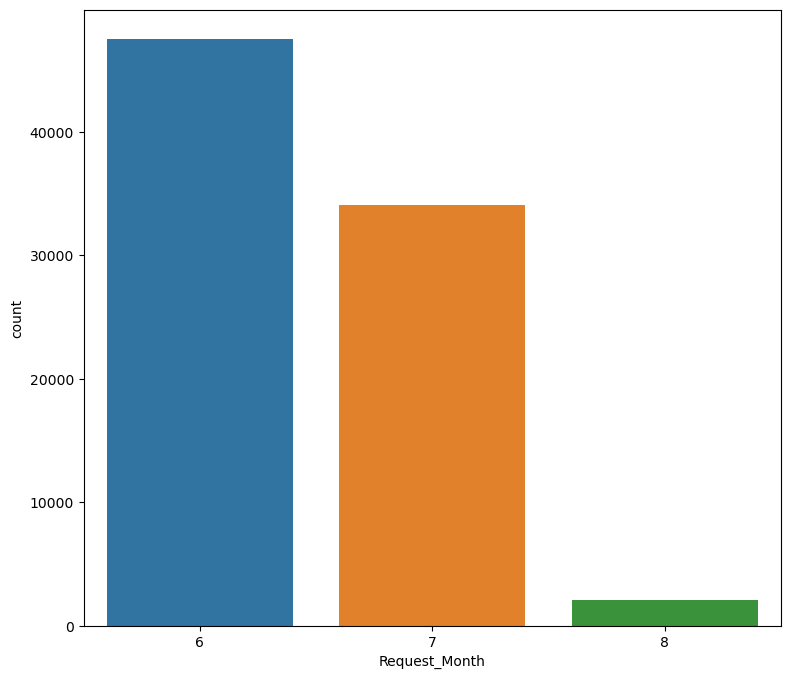

In [103]:
# Extract the month from the request date
df_train_copy['Request_Month'] = df_train_copy['Request_Date'].dt.month

# plot the request month
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_Month', data=df_train_copy);

The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August. 

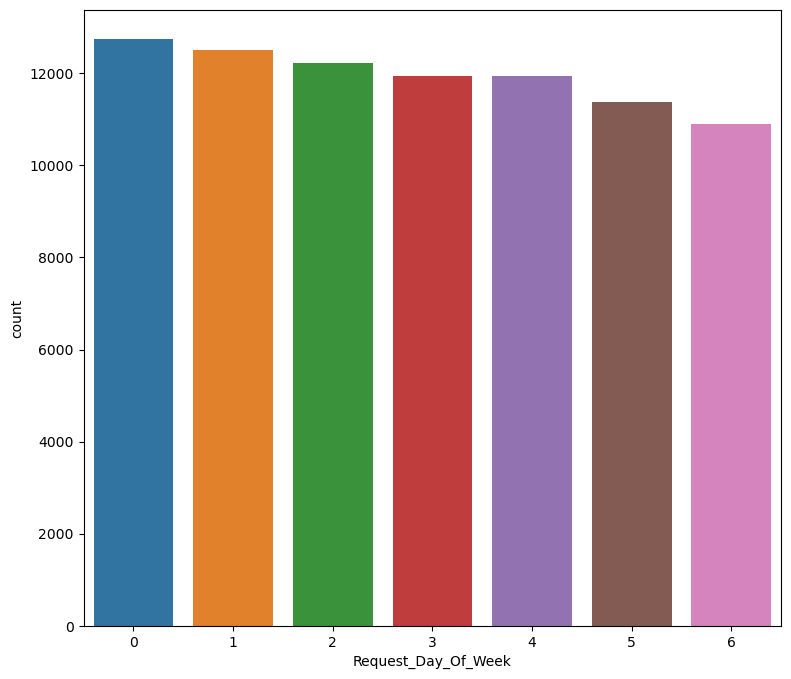

In [104]:
# Extract the day of the week from the request date
df_train_copy['Request_Day_Of_Week'] = df_train_copy['Request_Date'].dt.dayofweek
# 0 = Monday, 6 = Sunday

# plot the request day of the week
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_Day_Of_Week', data=df_train_copy);

There are nearly the same amount of requests on each day of the week.

2019-06-05 00:00:00
2019-09-10 00:00:00
[]


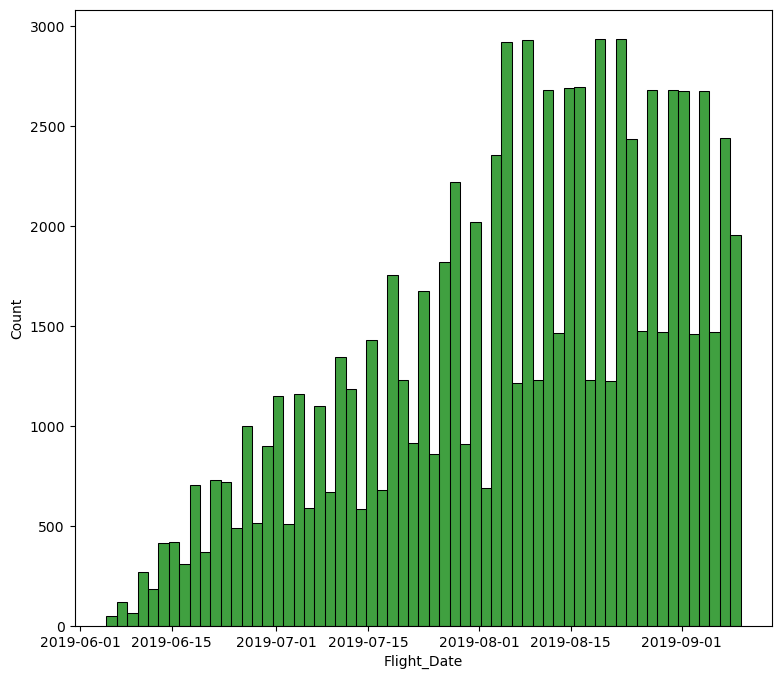

In [105]:
# check the distribution of flight date
# convert the flight date to datetime
df_train_copy['Flight_Date'] = pd.to_datetime(df_train_copy['Flight_Date'])

plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Flight_Date'], color='g');

# make a more useful plot for the flight date
# df_train_copy['Flight_Date'].value_counts().plot(figsize=(9, 8));

# get the first and the last flight date
print(df_train_copy['Flight_Date'].min())
print(df_train_copy['Flight_Date'].max())

# find dates in the data where no flight was scheduled
# create a list of dates in the date range
date_range = pd.date_range(start=df_train_copy['Flight_Date'].min(), end=df_train_copy['Flight_Date'].max())

# create a list of dates in flight date
flight_date = df_train_copy['Flight_Date'].unique()

# find the dates in the date range that are not in flight date
date_not_in_flight_date = [date for date in date_range if date not in flight_date]
print(date_not_in_flight_date)

The first flight left on 2019-06-05 and the last flight on 2019-09-10. On each day a flight was scheduled. There are no outliers in the flight date.

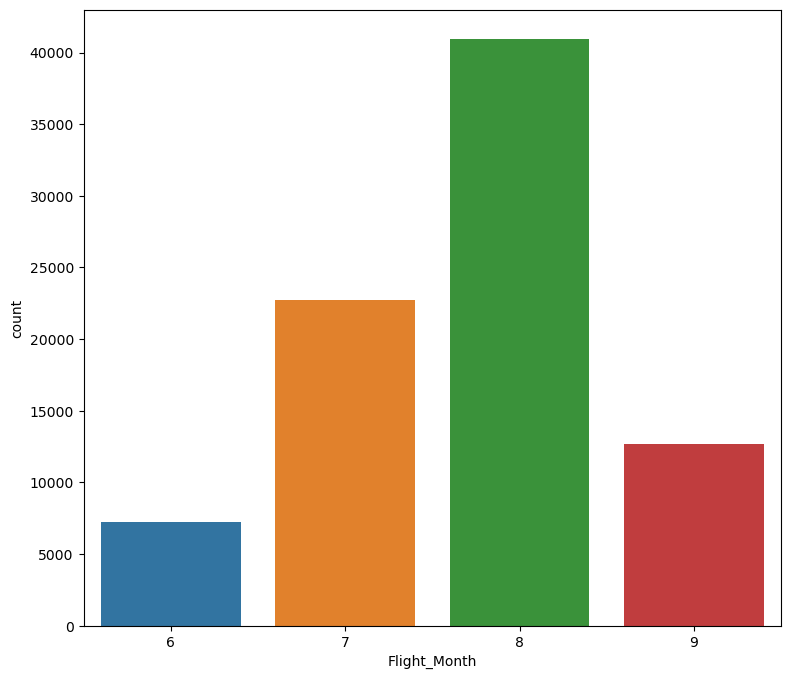

In [106]:
# Extract the month from the flight date
df_train_copy['Flight_Month'] = df_train_copy['Flight_Date'].dt.month

# plot the flight month
plt.figure(figsize=(9, 8))
sns.countplot(x='Flight_Month', data=df_train_copy);

Most flights depart in August, around half as many in July and only a few in September and even less in June.

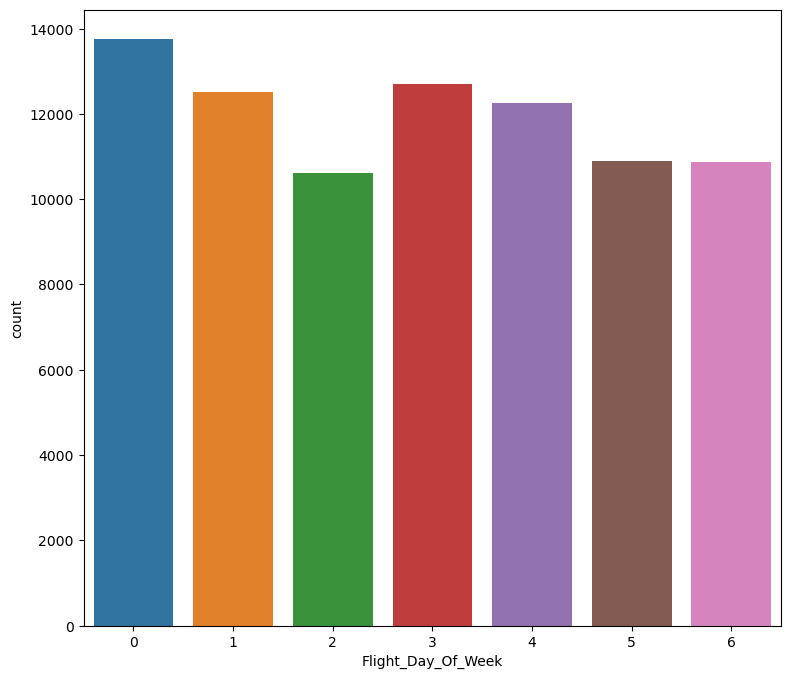

In [107]:
# Extract the day of the week from the flight date
df_train_copy['Flight_Day_Of_Week'] = df_train_copy['Flight_Date'].dt.dayofweek
# 0 = Monday, 6 = Sunday

# plot the flight day of the week
plt.figure(figsize=(9, 8))
sns.countplot(x='Flight_Day_Of_Week', data=df_train_copy);

In [108]:
# check data types of flight date and request date
print(df_train_copy['Flight_Date'].dtype)
print(df_train_copy['Request_Date'].dtype)

# remove the timezone from the request date
df_train_copy['Request_Date'] = df_train_copy['Request_Date'].dt.tz_convert(None)

# check dates, where the flight date is before the request date
flight_date_before_request_date = df_train_copy[df_train_copy['Flight_Date'] < df_train_copy['Request_Date']]

print(flight_date_before_request_date.shape[0])

datetime64[ns]
datetime64[ns, UTC]
0


There are no Flights where the flight date is before the request date.

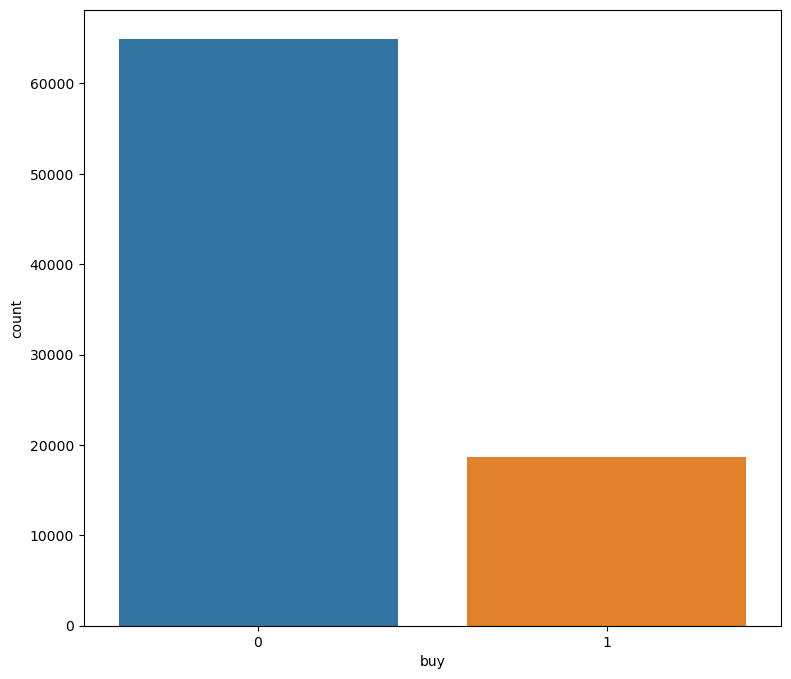

In [109]:
# check the distribution of buy
plt.figure(figsize=(9, 8))
sns.countplot(x='buy', data=df_train_copy);

There are more than three times more flights that should not be bought than flights that should be bought.

98
0
37.91360135846168
36.0


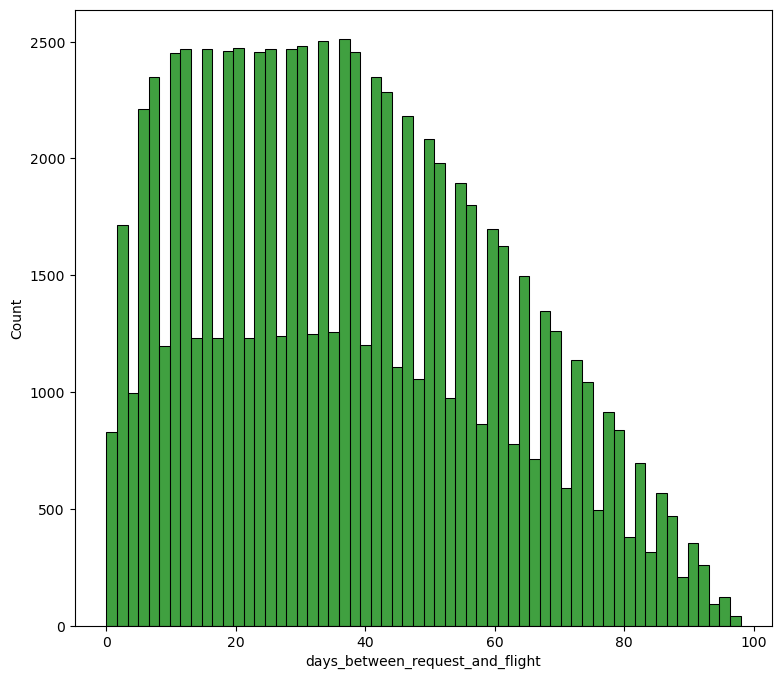

In [110]:
# check the distribution of the number of days between request date and flight date
df_train_copy['days_between_request_and_flight'] = (df_train_copy['Flight_Date'] - df_train_copy['Request_Date']).dt.days

plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['days_between_request_and_flight'], color='g');

# get the maximum number of days between request date and flight date
print(df_train_copy['days_between_request_and_flight'].max())
print(df_train_copy['days_between_request_and_flight'].min())

# get the average number of days between request date and flight date
print(df_train_copy['days_between_request_and_flight'].mean())

# get the median number of days between request date and flight date
print(df_train_copy['days_between_request_and_flight'].median())

There are between 0 and 98 days between the request date and the flight date.

The data exploration so far showed that:
-  *Request_date* and *flight_date* are of type object, but should be of type datetime
-  there are no missing values in the data
-  the *Price_In_Eur* is evenly distributed with fluctuations in the higher prices and some outliers around and above 350€.
-  the flights *Departure_hour* is between 6 and 22, most of them in the morning or in the evening, none between 12 and 16. There are no outliers.
-  the data contains 2 routes in *route_abb* with flights in both directions, so 4 routes: SXF-STN and STN-FRA. There are around 1.5 times more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA.. There are no outliers.
-  the data contains *Request_date*s from 2019-06-03 to 2019-08-03. There are no outliers. <br>
    The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August. <br>
    There are nearly the same amount of requests on each day of the week. There are no outliers.
-   the first *Flight_date* is on 2019-06-05 and the last flight on 2019-09-10. There are no outliers.
-   there are no flights where the flight date is before the request date.
-   there are more than three times more flights that are recommended not to *buy* than flights that should be bought.
-   there are between 0 and 98 days between the request date and the flight date.

1007


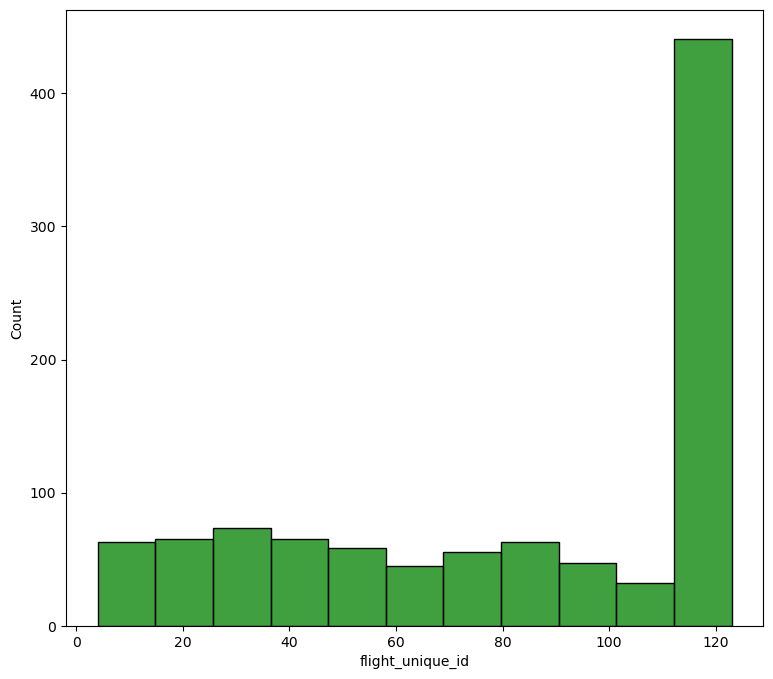

In [111]:
# check how many different flights are in the data
print(df_train_copy['flight_unique_id'].nunique())

# plot the number of requests for each flight
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['flight_unique_id'].value_counts(), color='g');

The distribution of the number of requests per flight shows that a small number of flights account for a disproportionately high share of total requests, while the majority of flights receive only a small number of requests.

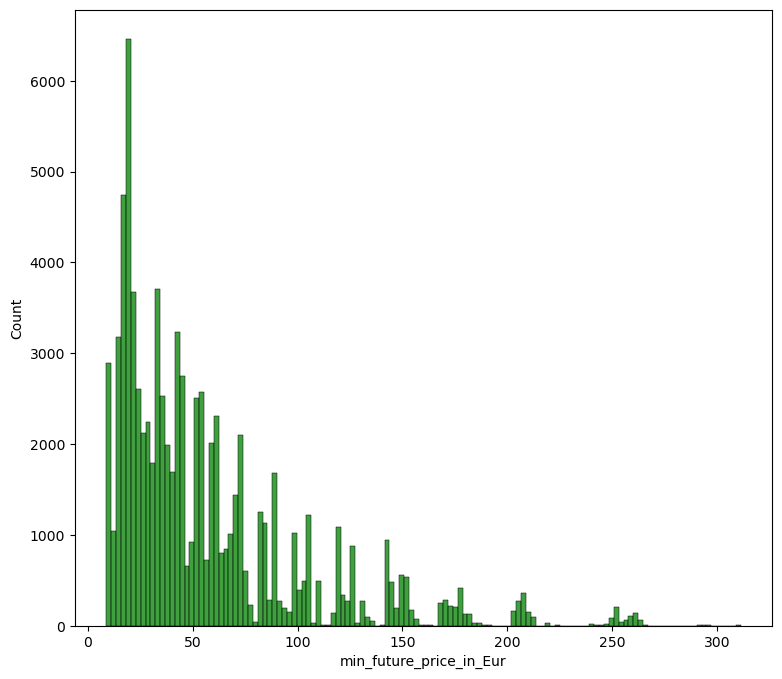

In [112]:
# check distribution of min_future_price_in_eur
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['min_future_price_in_Eur'], color='g');

64906


0.7761647373959629

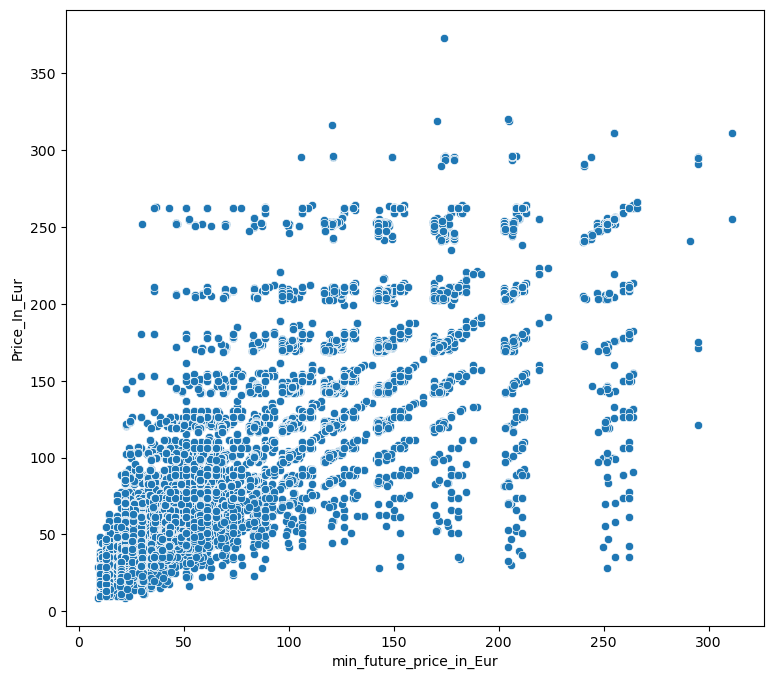

In [113]:
# compare the min_future_price_in_eur with the price_in_eur
plt.figure(figsize=(9, 8))
sns.scatterplot(x='min_future_price_in_Eur', y='Price_In_Eur', data=df_train_copy);

exceptions = df_train_copy[df_train_copy['Price_In_Eur'] > df_train_copy['min_future_price_in_Eur']]
print(exceptions.shape[0])

# Calculate the proportion of flights where the current price is higher than the minimum future price
exception_proportion = len(exceptions) / len(df_train_copy)
exception_proportion

There is a positive correlation between *Price_In_Eur* and *min_future_price_in_Eur*. About 77.6% of the flights have a current price that is higher than the minimum future price. Therefore, it seems to be the rule rather than the exception that the current price is higher than the minimum future price.

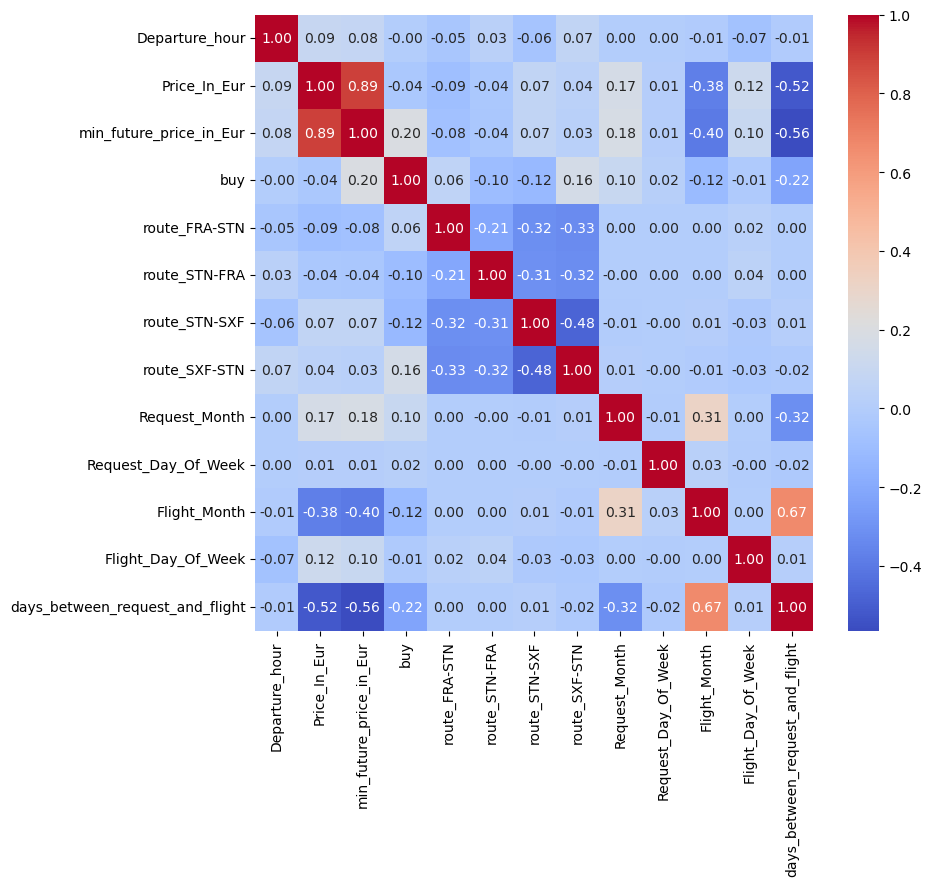

In [114]:
# Correlation matrix without index and flight_unique_id
df_train_copy_corr = df_train_copy.drop(['index', 'flight_unique_id'], axis=1)
plt.figure(figsize=(9, 8))
sns.heatmap(df_train_copy_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f');

- schwache positive Korrelation (-0.22) zwischen buy und days_between_request_and_flight_date. Dies könnte darauf hindeuten, dass Tickets, die weiter im Voraus angefragt werden, eher gekauft werden sollten.
- moderate negative Korrelation (-0.52) zwischen Price_in_Eur und days_between_request_and_flight_date. Dies könnte darauf hindeuten, dass Tickets, die weiter im Voraus angefragt werden, eher günstiger sind.
- moderate negative Korrelation (-0.56) zwischen min_future_price_in_Eur und days_between_request_and_flight. Dies könnte darauf hindeuten, dass Tickets, die weiter im Voraus angefragt werden, tendenziell einen niedrigeren minimalen zukünftigen Preis haben.

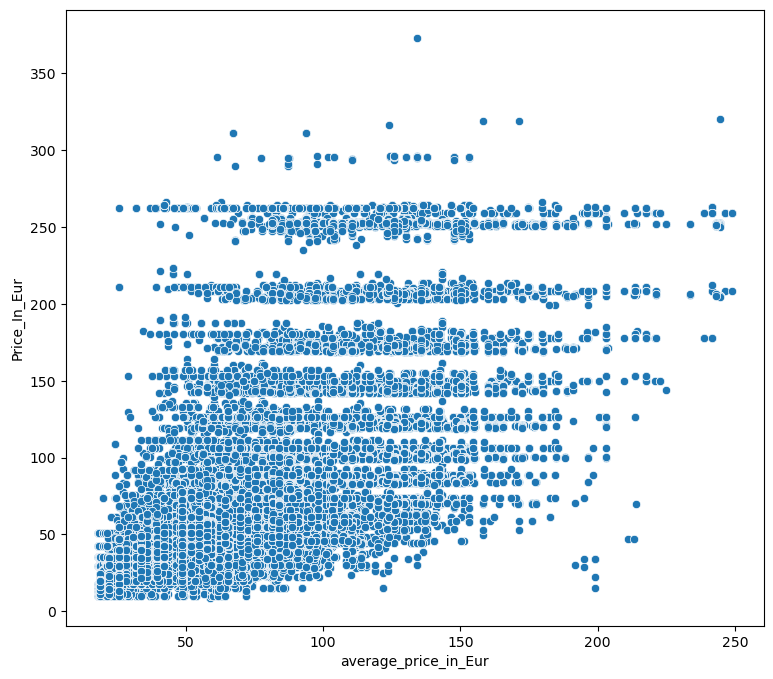

In [115]:
# Add a column with the average price for each flight
df_train_copy['average_price_in_Eur'] = df_train_copy.groupby('flight_unique_id')['Price_In_Eur'].transform('mean')

# Compare the average price with the current price
plt.figure(figsize=(9, 8))
sns.scatterplot(x='average_price_in_Eur', y='Price_In_Eur', data=df_train_copy);

## Prepare the data (Data Preparation) ##

## Try out different models and find the best ones (Model Selection) ##

In [116]:
# Define the features and the target
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve


X = df_train_copy[['Price_In_Eur', 'Request_Month', 'Flight_Month', 'days_between_request_and_flight']]
y = df_train_copy['buy']

# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature matrix
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a function to calculate the metrics
def calculate_metrics(y_test, y_pred):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('ROC AUC: ', roc_auc_score(y_test, y_pred))

# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Create a function to plot the Learning Curve
def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

### Random Forest Classifier ###	

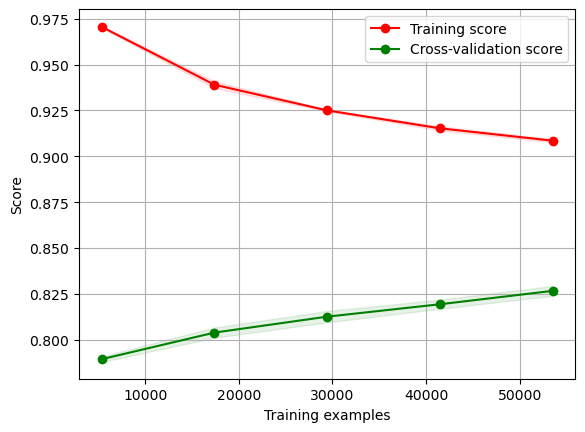

Accuracy:  0.9035411590606736
Precision:  0.8387045309508615
Recall:  0.7035128805620608
F1:  0.7651832174957243
ROC AUC:  0.8322969183962863


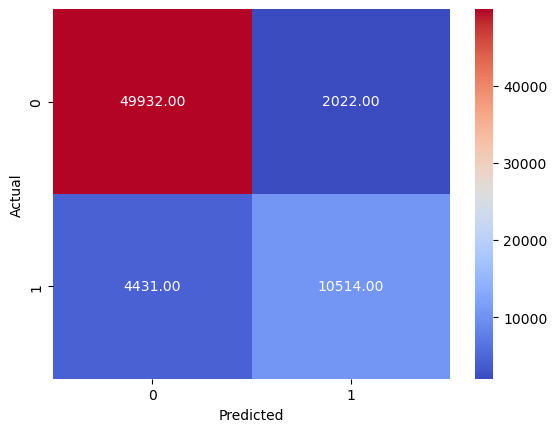

In [117]:
# Train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=200, random_state=42)
rfc.fit(X_train, y_train)
plot_learning_curve(rfc, X_train, y_train)
calculate_metrics(y_train, rfc.predict(X_train))
plot_confusion_matrix(y_train, rfc.predict(X_train))

Accuracy:  0.828998505231689
Precision:  0.6534453781512605
Recall:  0.5152398621786377
F1:  0.5761707172495554
ROC AUC:  0.7178191281245256


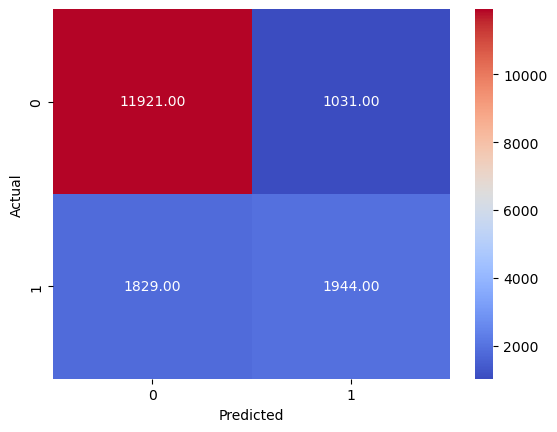

In [118]:
# predict the test data
y_pred = rfc.predict(X_test)
calculate_metrics(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

### Logistic Regression Classifier ###

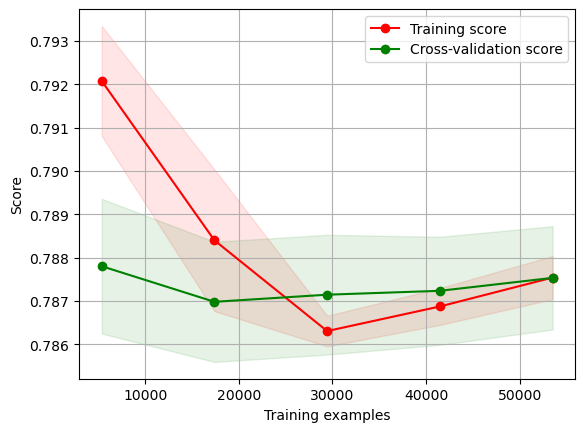

Accuracy:  0.7875155084530412
Precision:  0.7482993197278912
Recall:  0.07360321177651388
F1:  0.13402375875723424
ROC AUC:  0.5332407636046985


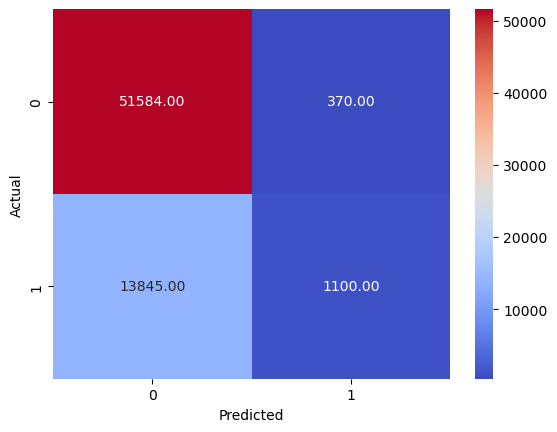

In [119]:
# Train a Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
plot_learning_curve(lr, X_train, y_train)
calculate_metrics(y_train, lr.predict(X_train))
plot_confusion_matrix(y_train, lr.predict(X_train))

## Fine-tune the models and combine them into a great solution (Model Tuning) ##